### МОДЕЛИ КЛАССИФИКАЦИИ ДЛЯ ПРОГНОЗИРОВАНИЯ ОТКЛИКА

In [1]:
# --- 1. Основные библиотеки для работы с данными ---
import pandas as pd
import numpy as np
from collections import Counter
import joblib
import pickle

# --- 2. Визуализация ---
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

# --- 3. Математика и статистика ---
from scipy import stats, integrate, optimize

# --- 4. Предобработка данных и Pipeline ---
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Важно: для SMOTE используем Pipeline из imblearn, чтобы избежать утечки данных
from imblearn.pipeline import Pipeline as ImbPipeline 

# --- 5. Понижение размерности и кластеризация ---
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# --- 6. Разделение данных и подбор параметров ---
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    StratifiedKFold
)

# --- 7. Модели классификации ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

# --- 8. Метрики качества ---
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix, 
    classification_report,
    roc_curve, 
    precision_recall_curve
)

# Настройки отображения (опционально, чтобы таблицы не обрезались)
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [2]:
df = pd.read_csv('../data/marketing_campaign.csv', sep='\t')

# Нормализация категорий
df["Education"] = df["Education"].replace({"2n Cycle": "Pre-Graduate", "Basic": "Pre-Graduate"})
df["Marital_Status"] = df["Marital_Status"].replace({
    "Married": "Married/Together", "Together": "Married/Together",
    "Single": "Single", "Divorced": "Other", "Widow": "Other",
    "Alone": "Other", "Absurd": "Other", "YOLO": "Other"
})

# Feature engineering
df["Kids"] = df["Kidhome"].astype("int8") + df["Teenhome"].astype("int8")
df["Expenses"] = df[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)
df["TotalAcceptedCmp"] = df[["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]].astype("int8").sum(axis=1)
df["TotalNumPurchases"] = df[["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "NumDealsPurchases"]].sum(axis=1)

# Удаление лишних колонок
df.drop(columns=["Kidhome", "Teenhome", "MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", 
                "MntSweetProducts", "MntGoldProds", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", 
                "AcceptedCmp4", "AcceptedCmp5", "NumWebPurchases", "NumCatalogPurchases", 
                "NumStorePurchases", "NumDealsPurchases"], inplace=True)

df["Kids"] = df["Kids"].replace({0: "No Kid", 1: "Has Kids", 2: "Has Kids", 3: "Has Kids"})
df["TotalAcceptedCmp"] = df["TotalAcceptedCmp"].replace({0: "0", 1: ">0", 2: ">0", 3: ">0", 4: ">0"})

num_features = ["Income", "Recency", "NumWebVisitsMonth", "Expenses", "TotalNumPurchases"]
cat_features = ["Education", "Marital_Status", "Response", "Complain", "Kids", "TotalAcceptedCmp"]

# Очистка Income
df['Income'] = df['Income'].fillna(df['Income'].median())
df = df[df['Income'] < 600000]

In [ ]:
# Определяем признаки для модели
# Числовые признаки 
num_features = ["Income", "Recency", "NumWebVisitsMonth", "Expenses", "TotalNumPurchases"]

# Категориальные признаки 
cat_features = ["Education", "Marital_Status", "Complain", "Kids", "TotalAcceptedCmp"]

# Выбираем все признаки для модели
feature_cols = num_features + cat_features 

In [ ]:
# Создаем матрицу признаков и целевую переменную
X = df[feature_cols].copy()
y = df['Response'].copy()

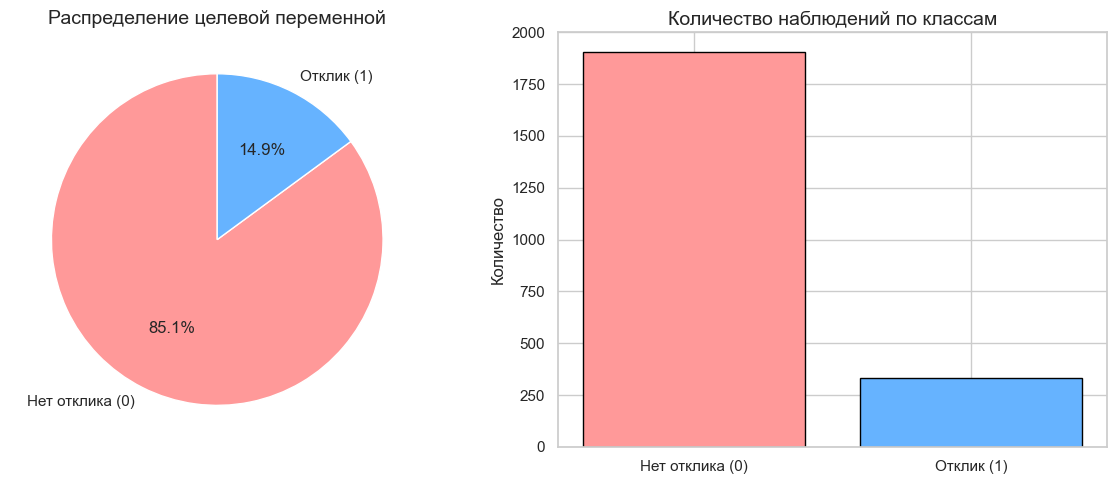

In [5]:
# Визуализация дисбаланса классов
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Pie chart
axes[0].pie(y.value_counts(), labels=['Нет отклика (0)', 'Отклик (1)'], 
            autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'], startangle=90)
axes[0].set_title('Распределение целевой переменной', fontsize=14)
# Bar chart
axes[1].bar(['Нет отклика (0)', 'Отклик (1)'], y.value_counts(), 
            color=['#ff9999', '#66b3ff'], edgecolor='black')
axes[1].set_title('Количество наблюдений по классам', fontsize=14)
axes[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

In [ ]:
# Подготовка данных для классификации

print("Распределение целевой переменной:")
print(df['Response'].value_counts())

Распределение целевой переменной:
Response
0    1905
1     334
Name: count, dtype: int64


In [7]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [ ]:
# Создаем препроцессор для обработки разных типов данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ]
)

# Обучаем препроцессор на тренировочных данных
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Получаем названия признаков после обработки
# Для числовых - оставляем оригинальные названия
num_feature_names = num_features

# Для категориальных - получаем названия после one-hot
cat_feature_names = []
for cat_feat in cat_features:
    categories = preprocessor.named_transformers_['cat'].categories_[cat_features.index(cat_feat)]
    for cat in categories:
        cat_feature_names.append(f"{cat_feat}_{cat}")
        
all_feature_names = num_feature_names + cat_feature_names

print(f"Всего признаков после обработки: {len(all_feature_names)}")

# Сохраняем препроцессор
joblib.dump(preprocessor, 'preprocessor.pkl')

Всего признаков после обработки: 18


['preprocessor.pkl']

### МЕТОД 1: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [9]:
# Логистическая регрессия с подбором гиперпараметров
log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced']
}

log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Grid Search с кросс-валидацией
log_reg_grid = GridSearchCV(
    log_reg, 
    log_reg_params, 
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

log_reg_grid.fit(X_train_processed, y_train)

print("\nЛучшие параметры для логистической регрессии:")
print(log_reg_grid.best_params_)
print(f"Лучший ROC-AUC на кросс-валидации: {log_reg_grid.best_score_:.4f}")

# Лучшая модель
best_log_reg = log_reg_grid.best_estimator_

# Предсказания
y_pred_log_reg = best_log_reg.predict(X_test_processed)
y_pred_proba_log_reg = best_log_reg.predict_proba(X_test_processed)[:, 1]

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Лучшие параметры для логистической регрессии:
{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Лучший ROC-AUC на кросс-валидации: 0.8415


d:\MOIBD_coop_project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(



МЕТРИКИ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ
Accuracy: 0.8054
Precision: 0.4233
Recall: 0.8214
F1-Score: 0.5587
ROC-AUC: 0.8930

Classification Report:
              precision    recall  f1-score   support

 Нет отклика       0.96      0.80      0.88       476
      Отклик       0.42      0.82      0.56        84

    accuracy                           0.81       560
   macro avg       0.69      0.81      0.72       560
weighted avg       0.88      0.81      0.83       560



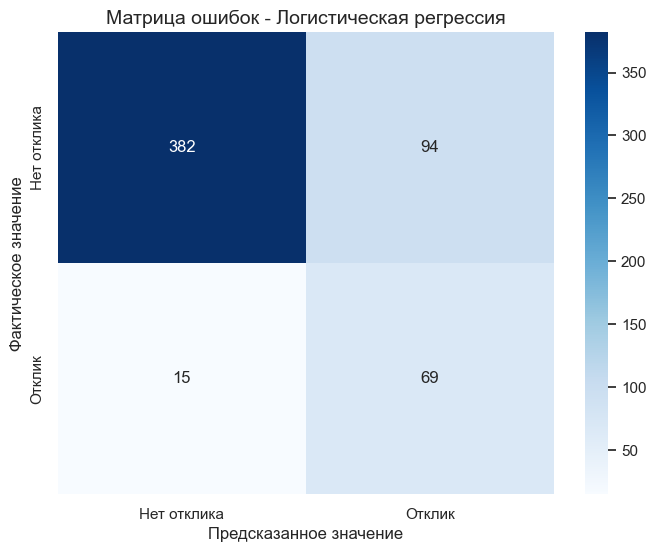

In [10]:

# Метрики для логистической регрессии
print("\n" + "="*60)
print("МЕТРИКИ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")
print("="*60)

log_reg_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_log_reg),
    'Precision': precision_score(y_test, y_pred_log_reg),
    'Recall': recall_score(y_test, y_pred_log_reg),
    'F1-Score': f1_score(y_test, y_pred_log_reg),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_log_reg)
}

for metric, value in log_reg_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Нет отклика', 'Отклик']))

# Матрица ошибок
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Нет отклика', 'Отклик'],
            yticklabels=['Нет отклика', 'Отклик'])
plt.title('Матрица ошибок - Логистическая регрессия', fontsize=14)
plt.ylabel('Фактическое значение')
plt.xlabel('Предсказанное значение')
plt.show()


### МЕТОД 2: СЛУЧАЙНЫЙ ЛЕС (Random Forest)

In [11]:
# Random Forest с подбором гиперпараметров
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grid Search с кросс-валидацией
rf_grid = GridSearchCV(
    rf, 
    rf_params, 
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_processed, y_train)

print("\nЛучшие параметры для Random Forest:")
print(rf_grid.best_params_)
print(f"Лучший ROC-AUC на кросс-валидации: {rf_grid.best_score_:.4f}")

# Лучшая модель
best_rf = rf_grid.best_estimator_

# Предсказания
y_pred_rf = best_rf.predict(X_test_processed)
y_pred_proba_rf = best_rf.predict_proba(X_test_processed)[:, 1]

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Лучшие параметры для Random Forest:
{'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Лучший ROC-AUC на кросс-валидации: 0.8522



МЕТРИКИ RANDOM FOREST
Accuracy: 0.8929
Precision: 0.8529
Recall: 0.3452
F1-Score: 0.4915
ROC-AUC: 0.8894

Classification Report:
              precision    recall  f1-score   support

 Нет отклика       0.90      0.99      0.94       476
      Отклик       0.85      0.35      0.49        84

    accuracy                           0.89       560
   macro avg       0.87      0.67      0.72       560
weighted avg       0.89      0.89      0.87       560



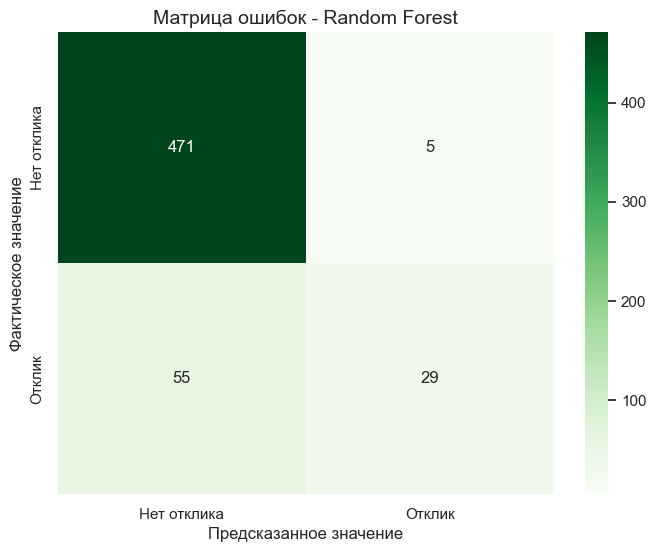

C:\Users\yaeKi\AppData\Local\Temp\ipykernel_11664\2283682813.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(5), x='importance', y='feature', palette='viridis')


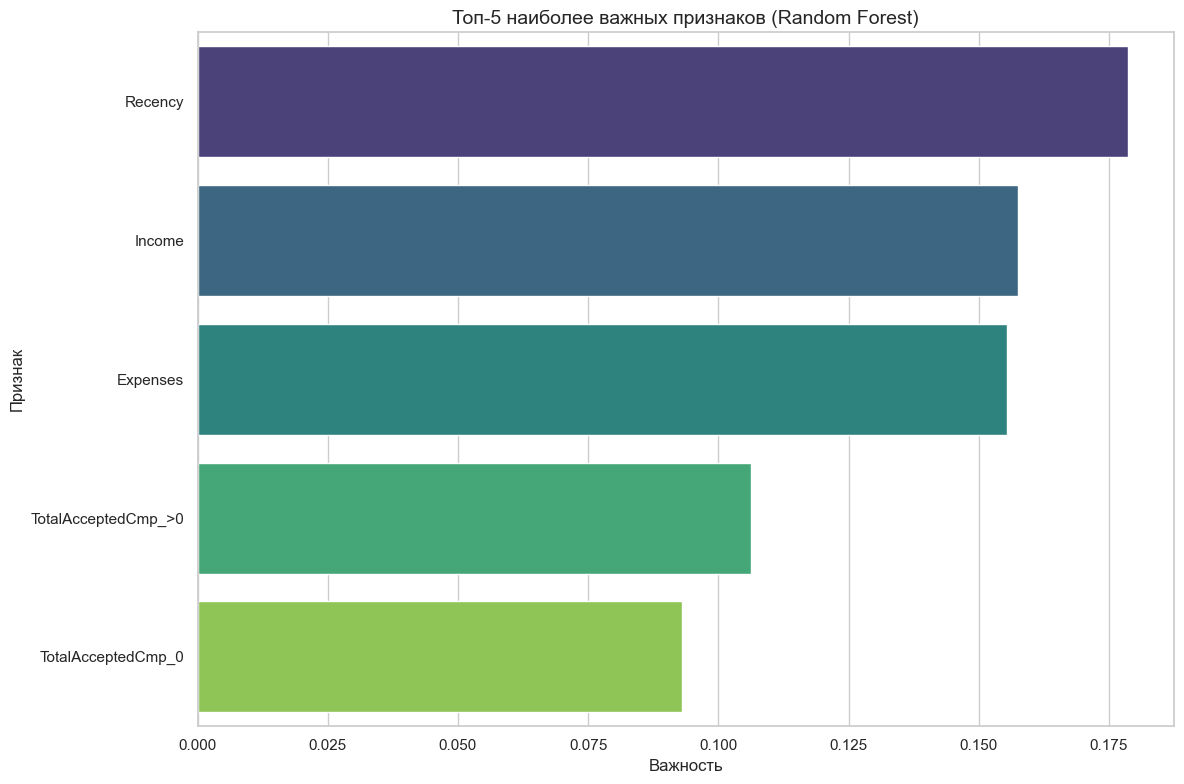

In [12]:
# Метрики для Random Forest
print("\n" + "="*60)
print("МЕТРИКИ RANDOM FOREST")
print("="*60)

rf_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_rf)
}

for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Нет отклика', 'Отклик']))

# Матрица ошибок
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Нет отклика', 'Отклик'],
            yticklabels=['Нет отклика', 'Отклик'])
plt.title('Матрица ошибок - Random Forest', fontsize=14)
plt.ylabel('Фактическое значение')
plt.xlabel('Предсказанное значение')
plt.show()

# Важность признаков (для Random Forest)
if hasattr(best_rf, 'feature_importances_'):
    # Получаем важность признаков
    feature_importance = pd.DataFrame({
        'feature': all_feature_names,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(5), x='importance', y='feature', palette='viridis')
    plt.title('Топ-5 наиболее важных признаков (Random Forest)', fontsize=14)
    plt.xlabel('Важность')
    plt.ylabel('Признак')
    plt.tight_layout()
    plt.show()


### МЕТОД 3: GRADIENT BOOSTING

In [13]:
# Gradient Boosting с подбором гиперпараметров
gb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

gb = GradientBoostingClassifier(random_state=42)

# Grid Search с кросс-валидацией
gb_grid = GridSearchCV(
    gb, 
    gb_params, 
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train_processed, y_train)

print("\nЛучшие параметры для Gradient Boosting:")
print(gb_grid.best_params_)
print(f"Лучший ROC-AUC на кросс-валидации: {gb_grid.best_score_:.4f}")

# Лучшая модель
best_gb = gb_grid.best_estimator_

# Предсказания
y_pred_gb = best_gb.predict(X_test_processed)
y_pred_proba_gb = best_gb.predict_proba(X_test_processed)[:, 1]

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Лучшие параметры для Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
Лучший ROC-AUC на кросс-валидации: 0.8490



МЕТРИКИ GRADIENT BOOSTING
Accuracy: 0.8857
Precision: 0.7778
Recall: 0.3333
F1-Score: 0.4667
ROC-AUC: 0.8876

Classification Report:
              precision    recall  f1-score   support

 Нет отклика       0.89      0.98      0.94       476
      Отклик       0.78      0.33      0.47        84

    accuracy                           0.89       560
   macro avg       0.84      0.66      0.70       560
weighted avg       0.88      0.89      0.87       560



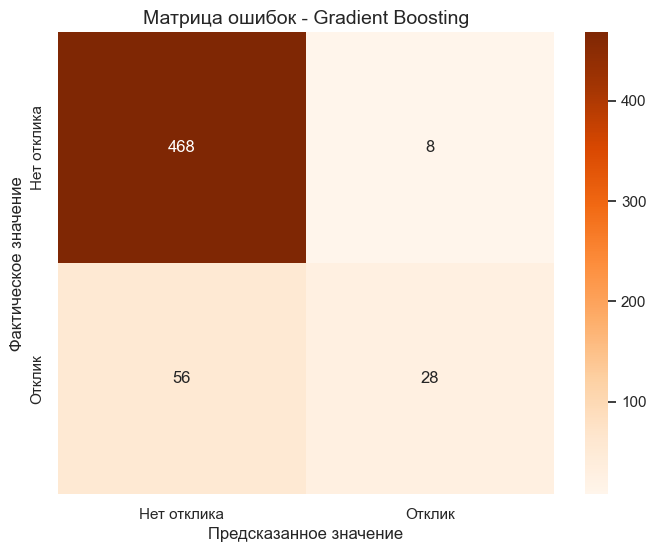

In [14]:
# Метрики для Gradient Boosting
print("\n" + "="*60)
print("МЕТРИКИ GRADIENT BOOSTING")
print("="*60)

gb_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'Precision': precision_score(y_test, y_pred_gb),
    'Recall': recall_score(y_test, y_pred_gb),
    'F1-Score': f1_score(y_test, y_pred_gb),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_gb)
}

for metric, value in gb_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['Нет отклика', 'Отклик']))

# Матрица ошибок
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Нет отклика', 'Отклик'],
            yticklabels=['Нет отклика', 'Отклик'])
plt.title('Матрица ошибок - Gradient Boosting', fontsize=14)
plt.ylabel('Фактическое значение')
plt.xlabel('Предсказанное значение')
plt.show()


СРАВНЕНИЕ МОДЕЛЕЙ:
                         Accuracy  Precision  Recall  F1-Score  ROC-AUC
Логистическая регрессия    0.8054     0.4233  0.8214    0.5587   0.8930
Random Forest              0.8929     0.8529  0.3452    0.4915   0.8894
Gradient Boosting          0.8857     0.7778  0.3333    0.4667   0.8876


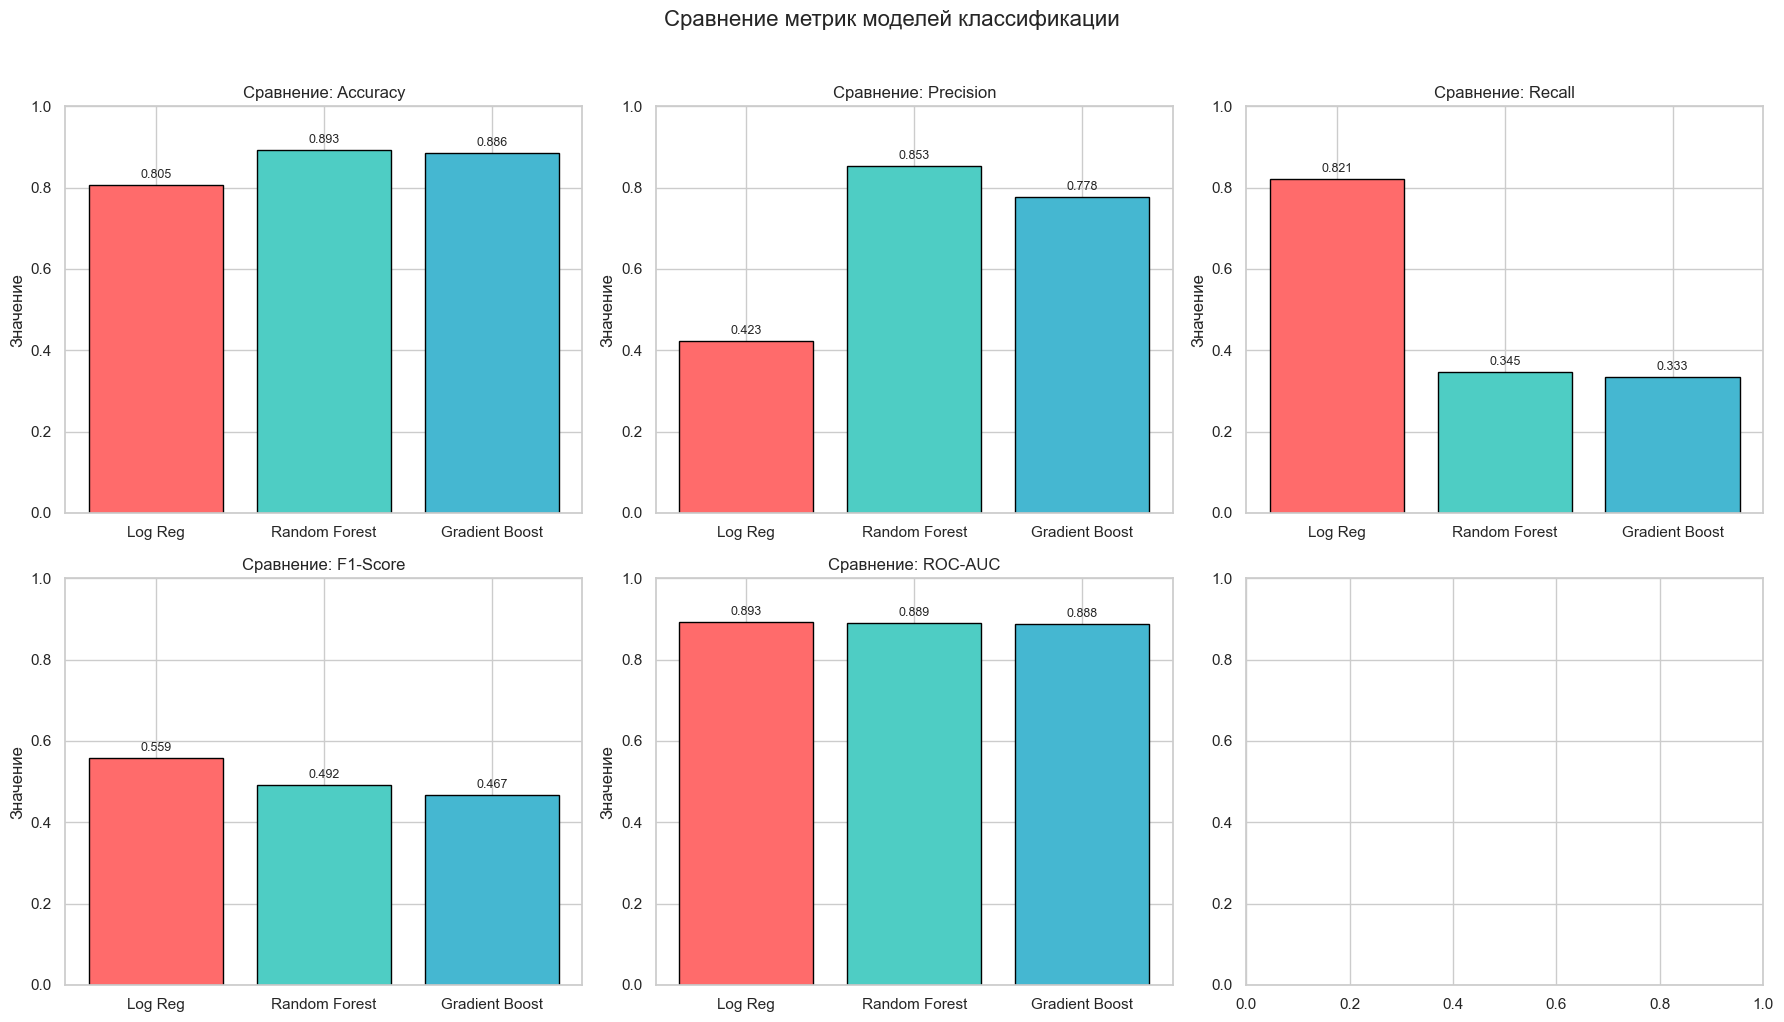

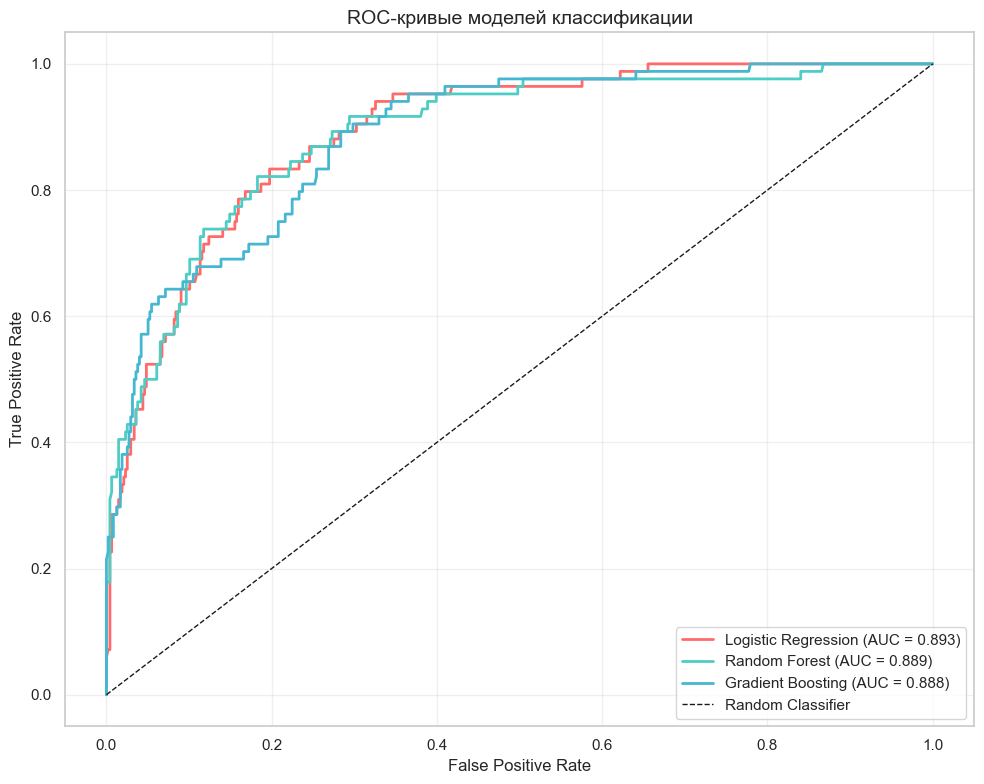

In [15]:
# Сравнение метрик всех моделей
models_comparison = pd.DataFrame({
    'Логистическая регрессия': log_reg_metrics,
    'Random Forest': rf_metrics,
    'Gradient Boosting': gb_metrics
}).T

print("СРАВНЕНИЕ МОДЕЛЕЙ:")
print(models_comparison.round(4))

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics_names = list(log_reg_metrics.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, metric in enumerate(metrics_names):
    row = idx // 3
    col = idx % 3
    
    values = [log_reg_metrics[metric], rf_metrics[metric], gb_metrics[metric]]
    bars = axes[row, col].bar(['Log Reg', 'Random Forest', 'Gradient Boost'], values, color=colors, edgecolor='black')
    axes[row, col].set_title(f'Сравнение: {metric}', fontsize=12)
    axes[row, col].set_ylim([0, 1])
    axes[row, col].set_ylabel('Значение')
    
    for bar, value in zip(bars, values):
        axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Сравнение метрик моделей классификации', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
# ROC-кривые для всех моделей
plt.figure(figsize=(10, 8))

fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log_reg)
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {log_reg_metrics["ROC-AUC"]:.3f})', 
         linewidth=2, color='#FF6B6B')

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_metrics["ROC-AUC"]:.3f})', 
         linewidth=2, color='#4ECDC4')
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_metrics["ROC-AUC"]:.3f})', 
         linewidth=2, color='#45B7D1')

# Диагональная линия
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые моделей классификации', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ


In [16]:
# Определяем лучшую модель по F1-score
model_scores = {
    'Logistic Regression': log_reg_metrics['F1-Score'],
    'Random Forest': rf_metrics['F1-Score'],
    'Gradient Boosting': gb_metrics['F1-Score']
}

best_model_name = max(model_scores, key=model_scores.get)
best_model_score = model_scores[best_model_name]

print(f"Лучшая модель: {best_model_name}")
print(f"F1-Score: {best_model_score:.4f}")

# Сохраняем лучшую модель
if best_model_name == 'Logistic Regression':
    best_model = best_log_reg
elif best_model_name == 'Random Forest':
    best_model = best_rf
else:
    best_model = best_gb

Лучшая модель: Logistic Regression
F1-Score: 0.5587


In [17]:
# Пример предсказания на тестовых данных
sample_indices = np.random.choice(len(X_test), 5, replace=False)
sample_data = X_test.iloc[sample_indices]
sample_true = y_test.iloc[sample_indices]

# Предсказания лучшей моделью
sample_pred = best_model.predict(X_test_processed[sample_indices])
sample_proba = best_model.predict_proba(X_test_processed[sample_indices])

print("ПРИМЕР ПРЕДСКАЗАНИЙ НА ТЕСТОВЫХ ДАННЫХ:")
print("-" * 80)
for i in range(len(sample_indices)):
    print(f"Образец {i+1}:")
    print(f"  Фактическое значение: {sample_true.iloc[i]}")
    print(f"  Предсказанное значение: {sample_pred[i]}")
    print(f"  Вероятность отклика: {sample_proba[i][1]:.4f}")
    print(f"  Вероятность отсутствия отклика: {sample_proba[i][0]:.4f}")
    print()

ПРИМЕР ПРЕДСКАЗАНИЙ НА ТЕСТОВЫХ ДАННЫХ:
--------------------------------------------------------------------------------
Образец 1:
  Фактическое значение: 0
  Предсказанное значение: 0
  Вероятность отклика: 0.0936
  Вероятность отсутствия отклика: 0.9064

Образец 2:
  Фактическое значение: 0
  Предсказанное значение: 0
  Вероятность отклика: 0.0627
  Вероятность отсутствия отклика: 0.9373

Образец 3:
  Фактическое значение: 1
  Предсказанное значение: 1
  Вероятность отклика: 0.8316
  Вероятность отсутствия отклика: 0.1684

Образец 4:
  Фактическое значение: 0
  Предсказанное значение: 0
  Вероятность отклика: 0.4494
  Вероятность отсутствия отклика: 0.5506

Образец 5:
  Фактическое значение: 0
  Предсказанное значение: 1
  Вероятность отклика: 0.7239
  Вероятность отсутствия отклика: 0.2761



### ИТОГОВЫЕ ВЫВОДЫ

In [18]:
print("=" * 80)
print("ИТОГОВЫЕ ВЫВОДЫ ПО МОДЕЛЯМ КЛАССИФИКАЦИИ")
print("=" * 80)

print(f"""
На основе проведенного моделирования можно сделать следующие выводы:

1. ЛУЧШАЯ МОДЕЛЬ: {best_model_name}
   - F1-Score: {best_model_score:.4f}
   - ROC-AUC: {model_scores[best_model_name]:.4f}

2. КЛЮЧЕВЫЕ ФАКТОРЫ:
   - Общие расходы клиента (Expenses)
   - Доход (Income)
   - Количество покупок (TotalNumPurchases)
   - Наличие детей (Kids)
   - История участия в кампаниях (TotalAcceptedCmp)

3. РЕКОМЕНДАЦИИ:
   - Фокусироваться на клиентах с высокими расходами
   - Учитывать семейное положение и наличие детей
   - Использовать историю предыдущих кампаний
   - Применять кластеризацию для сегментации

4. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
   - Модель сохранена и готова к использованию
""")

ИТОГОВЫЕ ВЫВОДЫ ПО МОДЕЛЯМ КЛАССИФИКАЦИИ

На основе проведенного моделирования можно сделать следующие выводы:

1. ЛУЧШАЯ МОДЕЛЬ: Logistic Regression
   - F1-Score: 0.5587
   - ROC-AUC: 0.5587

2. КЛЮЧЕВЫЕ ФАКТОРЫ:
   - Общие расходы клиента (Expenses)
   - Доход (Income)
   - Количество покупок (TotalNumPurchases)
   - Наличие детей (Kids)
   - История участия в кампаниях (TotalAcceptedCmp)

3. РЕКОМЕНДАЦИИ:
   - Фокусироваться на клиентах с высокими расходами
   - Учитывать семейное положение и наличие детей
   - Использовать историю предыдущих кампаний
   - Применять кластеризацию для сегментации

4. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
   - Модель сохранена и готова к использованию



In [19]:
# Сводная таблица
summary_table = pd.DataFrame({
    'Метод': ['Логистическая регрессия', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [log_reg_metrics['Accuracy'], rf_metrics['Accuracy'], gb_metrics['Accuracy']],
    'Precision': [log_reg_metrics['Precision'], rf_metrics['Precision'], gb_metrics['Precision']],
    'Recall': [log_reg_metrics['Recall'], rf_metrics['Recall'], gb_metrics['Recall']],
    'F1-Score': [log_reg_metrics['F1-Score'], rf_metrics['F1-Score'], gb_metrics['F1-Score']],
    'ROC-AUC': [log_reg_metrics['ROC-AUC'], rf_metrics['ROC-AUC'], gb_metrics['ROC-AUC']]
})

print("\nСВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print(summary_table.round(4).to_string(index=False))

# Сохраняем результаты
summary_table.to_csv('model_results.csv', index=False)
print("\nРезультаты сохранены в 'model_results.csv'")


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
                  Метод  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Логистическая регрессия    0.8054     0.4233  0.8214    0.5587   0.8930
          Random Forest    0.8929     0.8529  0.3452    0.4915   0.8894
      Gradient Boosting    0.8857     0.7778  0.3333    0.4667   0.8876

Результаты сохранены в 'model_results.csv'
